Ли-Зан-Мен Сергей

lizanmensergej@gmail.com

# 1.Тестовое задание

Нужно проверить статистические гипотезы о значимости признаков feature1 и feature2 (понять дают ли эти признаки какую-либо информацию для целевой переменной).

**Описание колонок:**

1. `time` - время подачи заявки или время оформления займа

1. `type` - тип записи в таблице (заявка или займ)

1. `amount` - сумма заявки/займа

1. `target` - целевая переменная

1. `feature1` - какой-то признак

1. `feature2` - какой-то признак

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency

import warnings
warnings.simplefilter('ignore')


%matplotlib inline

In [2]:
# Настройки для графиков
sns.set(style='whitegrid',
        font_scale=1.2,
        rc={'figure.figsize': (14, 6)})

In [3]:
# Функция для подписи графика
def sets_for_plot(plot, title='', title_fontsize=22, 
                  xlabel='', xlabel_fontsize=18, 
                  ylabel='', ylabel_fontsize=18):
    
    plot.set_title(title, fontsize=title_fontsize)
    plot.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    plot.set_ylabel(ylabel, fontsize=ylabel_fontsize)

 ## Загрузка и предобработка данных

In [4]:
# Загрузка датасета
feb_22_data = pd.read_csv('test_Feb22.csv', index_col=0)
feb_22_data.head()

,time,user_id,type,amount,target,feature1,feature2,events_ordinal_number,second_event_time,loan_ordinal_number,events_time_diff,previous_loans_max_amount
0,2001-01-01 00:00:00,114,loanRequest,14651,NaN,1,1,1,2001-01-25 05:00:00,1,NaN,NaN
1,2001-01-01 01:00:00,199,loanRequest,13398,NaN,0,0,1,2001-01-08 01:00:00,1,NaN,NaN
2,2001-01-01 02:00:00,717,loanRequest,14525,NaN,0,0,1,2001-01-09 16:00:00,1,NaN,NaN
3,2001-01-01 03:00:00,66,loan,14437,1.0,1,1,1,2001-03-27 17:00:00,1,NaN,NaN
4,2001-01-01 04:00:00,584,loanRequest,15861,NaN,1,0,1,2001-01-05 10:00:00,1,NaN,NaN


In [5]:
# Оставим только нужные поля
features_data = feb_22_data[['user_id', 'feature1', 'feature2', 'target']]
features_data.head(10)

,user_id,feature1,feature2,target
0,114,1,1,NaN
1,199,0,0,NaN
2,717,0,0,NaN
3,66,1,1,1.0
4,584,1,0,NaN
5,218,0,0,NaN
6,179,0,0,1.0
7,214,1,0,1.0
8,551,1,1,NaN
9,188,1,0,NaN


Видно, что для целевой переменной имеются пустые значения. Проверим признаки на наличие NAN

In [6]:
features_data.isna().sum()

user_id        0
feature1       0
feature2       0
target      7981
dtype: int64

In [7]:
# Заполним пропущенные значения
features_data.fillna(0, inplace=True)
features_data.head()

,user_id,feature1,feature2,target
0,114,1,1,0.0
1,199,0,0,0.0
2,717,0,0,0.0
3,66,1,1,1.0
4,584,1,0,0.0


Передохнем (ударение на е) и проанализируем ситуацию:
* Два номинативных признака
* Зависимая переменная - дихотомическая
* Требуется оценить наличие их влияния (по отдельности или в совокупности) на целевую переменную

Для начала необходимо оценить зависимость между признаками, ведь если зависимость присутствует (например, если f1 = 1, то f2 с вероятностью 90 % будет принимать значение 1), то включение обоих признаков в анализ может только ухудшить результаты.

Допустим гипотеза о независимости признаков подтвердилась, а что дальше?

При двух независимых номинативных признаках и дихотомической целевой переменной в моей голове всплывает два критерия: Q-критерий Кохрена и Критерий Хи-квадрат. 

После долгих размышлений я понял, что Q-критерий не подойдет под нашу конкретную ситуацию: если использовать в качестве воздействия f1 и f2, это не совсем логично, т.к. воздействия должны быть однородные, хотя если независимость признаков не подтвердится еще посмотрим:D. Еще была идея принимать в качестве воздействий месяца, в которые приходили юзеры, но не совсем ясно куда добавить признаки + в задании не требуется оценивать признак 'time'.

Остался критерий Хи-квадрат. В качестве условий будут всевозможные комбинации f1 и f2 , в качестве исхода результаты целевой переменной

# Оценим независимость признаков
Для того чтобы оценить зависимость двух номинативных переменных также используем критерий Хи-квадрат. В качестве целевой примем f2, хотя это и не принципиально.

H0: различия эмпирических и теоретических частот статистически не значительны

α = 0.05

In [8]:
# Рассчитаем таблицу сопряженности для двух переменных
obs_pivot = pd.pivot_table(data=features_data, index='feature1', 
                           columns='feature2', values='user_id', 
                           aggfunc='count')
obs_pivot

feature2,0,1
feature1,,
0,2008,1992
1,2992,3008


In [9]:
# Функция для рассчета критерия Хи-квадрат
def get_chi2(obs_data):
    # Без поправки Йетса
    chi_2 = chi2_contingency(obs_data, correction=False)
    
    # С поправкой Йетса
    chi_2_yates = chi2_contingency(obs_data)
    
    # Возвращает все параметры для критерия без поправки Йетса + 
    # chi2 и p для поправка Йетса
    return chi_2 + chi_2_yates[:2]

In [10]:
chi2, p, dof, ex, chi2_yates, p_yates = get_chi2(obs_pivot)

print('Эмпирические значения:\n', obs_pivot.values)
print('Теоретически ожидаемые значения:\n', ex)
print('\nЗначение pvalue для Хи-квадрат:', round(p, 4))
print('Значение pvalue с поправкой Йетса:', round(p_yates, 4))

Эмпирические значения:
 [[2008 1992]
 [2992 3008]]
Теоретически ожидаемые значения:
 [[2000. 2000.]
 [3000. 3000.]]

Значение pvalue для Хи-квадрат: 0.744
Значение pvalue с поправкой Йетса: 0.7595


Поправку Йетса использовать было не обязательно, т.к. число наблюдений велико, но как истинный аналитик я попробовал. Результаты не различаются и в обоих случаях p-value выше 0.05.

Значит ли это что получилось доказать независимость признаков?

Нет:)


<img src="https://i.kym-cdn.com/photos/images/newsfeed/002/205/307/1f7.jpg" width= 200;/>

Все из-за того, что в наших наблюдениях есть проблема: критерий хи-квадрат предполагает независимость выборок, в нашем случае на каждого юзера приходится несколько наблюдений. Чтобы получить независимые выборки найдем для каждого клиента моду.

In [11]:
# Статистики для f1
features_data.groupby('user_id').feature1.describe().head()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
0,12.0,0.500000,0.522233,0.0,0.0,0.5,1.0,1.0
1,15.0,0.400000,0.507093,0.0,0.0,0.0,1.0,1.0
2,17.0,0.705882,0.469668,0.0,0.0,1.0,1.0,1.0
3,9.0,0.888889,0.333333,0.0,1.0,1.0,1.0,1.0
4,11.0,0.545455,0.522233,0.0,0.0,1.0,1.0,1.0


Видно, что значение медианы идеально описывает нашу моду.

In [12]:
# Значения популярные значения признаков для юзеров
mods_for_users = features_data.groupby('user_id', as_index=False) \
                              .agg({'feature1': 'median', 'feature2': 'median'})
mods_for_users.head()

,user_id,feature1,feature2
0,0,0.5,1.0
1,1,0.0,1.0
2,2,1.0,1.0
3,3,1.0,0.0
4,4,1.0,1.0


Т.к. переменные номинативные необходимо избавиться от значения 0.5. Т.к. признаки могут быть чем угодно нельзя предположить какое значение должно встречаться чаще, поэтому округлим в обе стороны и сравним полученные значения.

Если возникнет ситуация p < 0.05, возможно потребуется более гибкое усреднение значения 0.5

In [13]:
# Округлим значения
round_mode_1 = mods_for_users.replace({0.5: 1})
round_mode_0 = mods_for_users.replace({0.5: 0})

In [14]:
# Сформируем эмперические выборки
obs_1_pivot = pd.pivot_table(data=round_mode_1, index='feature1', 
                           columns='feature2', values='user_id', 
                           aggfunc='count')

obs_1_pivot

feature2,0.0,1.0
feature1,,
0.0,96,112
1.0,348,444


In [15]:
obs_0_pivot = pd.pivot_table(data=round_mode_0, index='feature1', 
                           columns='feature2', values='user_id', 
                           aggfunc='count')
obs_0_pivot

feature2,0.0,1.0
feature1,,
0.0,179,141
1.0,382,298


In [16]:
chi2, p_1, dof, ex_1, chi2_yates, p_yates = get_chi2(obs_1_pivot)
chi2, p_0, dof, ex_0, chi2_yates, p_yates = get_chi2(obs_0_pivot)

print('Эмпирические значения при округлении до 1:\n', obs_1_pivot.values)
print('Эмпирические значения при округлении до 0:\n', obs_0_pivot.values)

print('\nТеоретические значения при округлении до 1:\n', ex_1)
print('Теоретические значения при округлении до 0:\n', ex_0)

print('\nЗначение pvalue для Хи-квадрат при округлении до 1:', round(p_1, 4))
print('Значение pvalue для Хи-квадрат при округлении до 0:', round(p_0, 4))

Эмпирические значения при округлении до 1:
 [[ 96 112]
 [348 444]]
Эмпирические значения при округлении до 0:
 [[179 141]
 [382 298]]

Теоретические значения при округлении до 1:
 [[ 92.352 115.648]
 [351.648 440.352]]
Теоретические значения при округлении до 0:
 [[179.52 140.48]
 [381.48 298.52]]

Значение pvalue для Хи-квадрат при округлении до 1: 0.5673
Значение pvalue для Хи-квадрат при округлении до 0: 0.9434


В обоих случаях p > 0.05. Причем при округлении до нуля эмпирическая выборка почти идеально совпадает с теоретически ожидаемыми значениями. 
Теперь у меня есть основания полагать, что признаки f1 и f2 статистически независимы. Нулевая гипотеза не отвергается.


# Оценка значимости признаков для целевой переменной
H0: различия эмпирических и теоретических частот статистически не значительны

α = 0.05

In [17]:
# Колличество наблюдений с Y=1
features_data.query('target == 1').shape

(1048, 4)

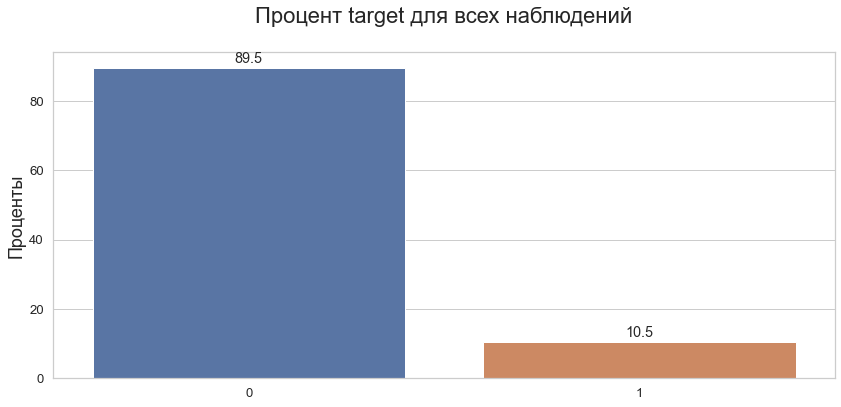

In [18]:
# Распределение целевой переменной для всех наблюдений
norm_target = (features_data
               .target
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())
bp = sns.barplot(data=norm_target, y='percent', x='index')
bp.set_xticklabels([0,1])
sets_for_plot(plot=bp, title='Процент target для всех наблюдений\n',
              ylabel='Проценты')

# Вывод значений над столбцами
for p in bp.patches:
    bp.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [19]:
# Мода f1, f2, Y для каждого пользователя
mods_for_users_with_target = features_data.groupby('user_id', as_index=False) \
                              .agg({'feature1': 'median', 'feature2': 'median', 'target': 'median'})
mods_for_users_with_target.query('target == 1 or target == 0.5')

,user_id,feature1,feature2,target
595,595,0.5,1.0,0.5
797,797,1.0,0.0,1.0
900,900,1.0,1.0,1.0
949,949,0.5,0.0,0.5


Видно, что изначально target принимал значение 1 с шансом 1:9. При подсчете моды неудивительно, что всего 4 наблюдения получили значение моды отличное от нуля

In [20]:
# От вариаций округления будет меняться и значение хи-квадрат

for f_round in range(2):
    for y_round in range(2):
        df = mods_for_users_with_target.copy()
        df.feature1 = df.feature1.replace({0.5:f_round})
        df.feature2 = df.feature2.replace({0.5:f_round})
        df.target = df.target.replace({0.5:y_round})
        
        obs = pd.pivot_table(data=df, index=['feature1', 'feature2'], 
                           columns='target', values='user_id', 
                           aggfunc='count')
        obs.fillna(0, inplace=True)
        
        chi2, p, dof, ex, chi2_yates, p_yates = get_chi2(obs)
        
        print(f'{f_round=}, {y_round=} \n')
        print('Эмпирические значения:\n', obs.values)
        print('Теоретически ожидаемые значения:\n', ex.round(1))
        print('\nЗначение pvalue для Хи-квадрат:', round(p, 4))
        print('Значение pvalue с поправкой Йетса:', round(p_yates, 4))
        print('==========================\n')

f_round=0, y_round=0 

Эмпирические значения:
 [[179.   0.]
 [141.   0.]
 [381.   1.]
 [297.   1.]]
Теоретически ожидаемые значения:
 [[1.786e+02 4.000e-01]
 [1.407e+02 3.000e-01]
 [3.812e+02 8.000e-01]
 [2.974e+02 6.000e-01]]

Значение pvalue для Хи-квадрат: 0.804
Значение pvalue с поправкой Йетса: 0.804

f_round=0, y_round=1 

Эмпирические значения:
 [[178   1]
 [140   1]
 [381   1]
 [297   1]]
Теоретически ожидаемые значения:
 [[178.3   0.7]
 [140.4   0.6]
 [380.5   1.5]
 [296.8   1.2]]

Значение pvalue для Хи-квадрат: 0.8812
Значение pvalue с поправкой Йетса: 0.8812

f_round=1, y_round=0 

Эмпирические значения:
 [[ 96.   0.]
 [112.   0.]
 [347.   1.]
 [443.   1.]]
Теоретически ожидаемые значения:
 [[9.580e+01 2.000e-01]
 [1.118e+02 2.000e-01]
 [3.473e+02 7.000e-01]
 [4.431e+02 9.000e-01]]

Значение pvalue для Хи-квадрат: 0.9046
Значение pvalue с поправкой Йетса: 0.9046

f_round=1, y_round=1 

Эмпирические значения:
 [[ 96.   0.]
 [112.   0.]
 [346.   2.]
 [442.   2.]]
Теоретически

Ни для одной комбинации не имеет смысла отвергать H0. Вывод ни один из признаков (а также их комбинация) не оказывают статистически значимого влияния на целевую переменную

#### Попробую также провести проверку хи-квадрат, если абстрагироваться от того, что наблюдения получены от одних и тех же клиентов

In [21]:
obs = pd.pivot_table(data=features_data, index=['feature1', 'feature2'], 
                    columns='target', values='user_id', 
                    aggfunc='count')
obs

target              0.0  1.0
feature1 feature2           
0        0         1888  120
         1         1894   98
1        0         2558  434
         1         2612  396

In [22]:
chi2, p, dof, ex, chi2_yates, p_yates = get_chi2(obs)
print(f'Значение хи-квадрат: {chi2}')
print('Эмпирические значения:\n', obs.values)
print('Теоретически ожидаемые значения:\n', ex.round(1))
print('\nЗначение pvalue для Хи-квадрат:', p)
print('Значение pvalue с поправкой Йетса:', p_yates)

Значение хи-квадрат: 183.8514823029023
Эмпирические значения:
 [[1888  120]
 [1894   98]
 [2558  434]
 [2612  396]]
Теоретически ожидаемые значения:
 [[1797.6  210.4]
 [1783.2  208.8]
 [2678.4  313.6]
 [2692.8  315.2]]

Значение pvalue для Хи-квадрат: 1.2991961595479963e-39
Значение pvalue с поправкой Йетса: 1.2991961595479963e-39


В данном случае значимость действительно обнаружена, но при это значение Хи-квадрат неоправданно большое, а p-value слишком маленькое. Связь просто космическая. Это заставляет сомневаться в результатах данного теста

# Логистической регрессия
Подтвержает обе ситуации

In [23]:
import statsmodels.formula.api as smf
model = smf.logit(formula = 'target ~ feature1 + feature2 + feature1 * feature2', 
                  data = features_data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.325557
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Sun, 20 Feb 2022   Pseudo R-squ.:                 0.02964
Time:                        09:08:57   Log-Likelihood:                -3255.6
converged:                       True   LL-Null:                       -3355.0
Covariance Type:            nonrobust   LLR p-value:                 7.220e-43
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.7558      0.094    -29.272      0.000      -2.940      -2.571
feature1              0.9818      0.108      9.133      0.000       0.771       1.193
feature2             -0.2057      0.140     -1.469      0.142      -0.480       0.069
feature1:feature2     0.0932      0.159      0.587      0.557      -0.218       0.404
=====================================================================================
"""

Учитываем все наблюдения, то все признаки значимы по pvalue

In [24]:
model = smf.logit(formula = 'target ~ feature1 + feature2 + feature1 * feature2', 
                  data = mods_for_users_with_target.replace({0.5: 1})).fit()
model.summary()

         Current function value: 0.025113
         Iterations: 35


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Sun, 20 Feb 2022   Pseudo R-squ.:                 0.03699
Time:                        09:08:57   Log-Likelihood:                -25.113
converged:                      False   LL-Null:                       -26.078
Covariance Type:            nonrobust   LLR p-value:                    0.5872
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -21.8029   5537.285     -0.004      0.997   -1.09e+04    1.08e+04
feature1             16.6496   5537.285      0.003      0.998   -1.08e+04    1.09e+04
feature2              4.2174   5572.148      0.001      0.999   -1.09e+04    1.09e+04
feature1:feature2    -4.4622   5572.148     -0.001      0.999   -1.09e+04    1.09e+04
=====================================================================================

Possibly complete quasi-separation: A fraction 0.21 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Берем моду от каждого клиента, то комбинации признаков не значимы по pvalue

# 2.Тестовое задание

В данном задании необходимо написать код, который считает следующие признаки для каждого клиента `user_id`:

1. `events_ordinal_number` - порядковый номер события
2. `second_event_time` - время второго события
2.	`loan_ordinal_number` - порядковый номер займа
2.	`events_time_diff` - разница во времени между событиями
2.	`previous_loans_max_amount` - максимальная сумма предыдущего займа.


### Подготовка датафрейма

In [25]:
import numpy as np

from datetime import datetime

In [26]:
size = 10000

df = pd.DataFrame(
    {
        'time': [*pd.date_range('2001-01-01', '2020-09-01', freq='1h')][:size],
        'user_id': np.random.choice(1000, size),
        'type': np.random.choice(2, size, p=[0.8, 0.2]),
        'amount': [int(x//1) for x in np.random.normal(15_000, 1_000, size)],
        'target': np.random.choice(2, size, p=[0.5, 0.5]),
    },
    index=[*range(size)],
)

In [27]:
df['is_loan'] = df['type']
df['type'] = df['type'].replace({0: 'loanRequest', 1: 'loan'})

In [28]:
df.to_csv('test_origin.csv', index=False)

### Расчет признаков

#### Признак `events_ordinal_number`

In [29]:
# весь код расчета признака должен быть в этом методе
def calculate_events_number(df):
    # Словарь для отслеживания количества событий для каждого клиента
    users_numbers_dict = {}

    # Функция для проверки количества запросов от данного клиента
    def check_user(user_id):
        # Если он был
        if user_id in users_numbers_dict:
            users_numbers_dict[user_id] += 1
        # Если его не было
        else:
            users_numbers_dict[user_id] = 1

        return users_numbers_dict[user_id]

    # Необходимо чтобы df был отсортирован по дате события
    df = df.sort_values('time')
    df['events_ordinal_number'] = df.user_id.apply(check_user)

    return df

#### Признак `second_event_time`

In [30]:
# весь код расчета признака должен быть в этом методе
def calculate_second_event_time(df):
    # Словарь для отслеживания второго события каждого клиента
    users_second_dict = {}

    # Функция возвращающая время второго прихода клиента, если такое есть
    def get_second_event_time(user_id):
        try:
            # Если не известно значение второго события, то пытаемся найти его по запросу
            if user_id not in users_second_dict:
                users_second_dict[user_id] = user_time_events \
                    .query('user_id == @user_id & events_ordinal_number == 2') \
                    .time \
                    .iloc[0]
            return users_second_dict[user_id]

        # В случае, если значения второго события нет, то iloc[0] отловит IndexError
        except IndexError:
            pass

    # Рассчитаем по готовой функции номер каждого события если их нет
    if 'events_ordinal_number' not in df.columns:
        df = calculate_events_number(df)

    # Отбираем только нужные поля
    user_time_events = df[['user_id', 'time', 'events_ordinal_number']]

    df['second_event_time'] = user_time_events.user_id.apply(
        get_second_event_time)

    return df

#### Признак `loan_ordinal_number`

In [31]:
# весь код расчета признака должен быть в этом методе
def calculate_loan_number(df):

    # Словарь для отслеживания количества заявок для каждого клиента и предыдущий тип действия
    users_loan_numbers_dict = {}

    # Функция для проверки количества заявок от данного клиента
    def check_loan_by_users(user_id, type_event):

        # Если клиент впервые совершил дейтсвие
        if user_id not in users_loan_numbers_dict:
            users_loan_numbers_dict[user_id] = [type_event, 1]

        # Если тип заявка
        elif users_loan_numbers_dict[user_id][0] == 'loan':
            users_loan_numbers_dict[user_id][1] += 1

        users_loan_numbers_dict[user_id][0] = type_event
        return users_loan_numbers_dict[user_id][1]

    # Необходимо чтобы df был отсортирован по дате события
    df = df.sort_values('time')
    df['loan_ordinal_number'] = [check_loan_by_users(user_id, type_event)
                                 for user_id, type_event in df[['user_id', 'type']].values]

    return df

#### Признак `events_time_diff`

In [32]:
# весь код расчета признака должен быть в этом методе
def calculate_time_diff(df):

    # Словарь для отслеживания времени предыдущего события для клиента
    times_previous_event_dict = {}

    # Функция для получение дельты между датой текущего события и предыдущего
    def difference_from_previous_date(user_id, time):

        # Если клиент впервые совершил дейтсвие
        if user_id not in times_previous_event_dict:
            times_previous_event_dict[user_id] = time
            return np.nan

        # Если нет, то вернем разницу во времени с предыдущим событием
        else:
            delta = time - times_previous_event_dict[user_id]
            times_previous_event_dict[user_id] = time
            return delta

    # Необходимо чтобы df был отсортирован по дате события
    df = df.sort_values('time')
    df['events_time_diff'] = [difference_from_previous_date(user_id, time)
                              for user_id, time in df[['user_id', 'time']].values]

    return df

#### Признак `previous_loans_max_amount`

In [33]:
# весь код расчета признака должен быть в этом методе
def calculate_previous_max_amount(df):

    # Словарь для отслеживания максимальной суммы займа для каждого клиента
    max_amount_dict = {}

    # Функция для определения предыдущей суммы займа
    def max_amount(user_id, type_event, amount):

        # Если клиент впервые совершил займ, то добавим его в словарь
        if user_id not in max_amount_dict and type_event == 'loan':
            max_amount_dict[user_id] = amount
            return np.nan

        # Если событие-займ, то вернем предыдущее и рассчитаем максимальное
        elif type_event == 'loan':
            previous_max_amount = max_amount_dict[user_id]
            max_amount_dict[user_id] = max(amount, previous_max_amount)
            return previous_max_amount

        # Если пользователь уже совершал займ, то возвращать его величину
        if user_id in max_amount_dict:
            return max_amount_dict[user_id]

    # Необходимо чтобы df был отсортирован по дате события
    df = df.sort_values('time')
    df['previous_loans_max_amount'] = [max_amount(user_id, type_event, amount)
                                       for user_id, type_event, amount in df[['user_id', 'type', 'amount']].values]

    return df

### Сохранение итогового датасета с признаками

Этот код трогать не нужно.

In [34]:
def calculate_feature(df):
    calculate_events_number(df)
    calculate_second_event_time(df)
    calculate_loan_number(df)
    calculate_time_diff(df)
    calculate_previous_max_amount(df)

In [35]:
%%timeit -o
calculate_feature(df)

1.81 s ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.81 s ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [36]:
columns = ['time']
rez = _
df_time = pd.DataFrame([rez], None, columns)
df_time.to_csv('time.csv', index=False)

In [37]:
df.to_csv('test.csv', index=False)